In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [7]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [8]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [9]:
df = pd.read_csv("/content/drive/MyDrive/ML/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [10]:
# ## load dataset here
# df = pd.read_csv("icml_face_data.csv")
# df.head()

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [11]:
len(df)

35887

### Preprocessing

In [12]:
df.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [13]:
df.duplicated().sum()

1793

In [14]:
df=df.drop_duplicates()

In [15]:
len(df)

34094

In [16]:
# splitting each string of pixel values and converting to array
pixels = df['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' '))

# creating function to find images with only 1 unique pixel value -- if it's only 1 unique pixel value then the image is just one color
def same_pixel_value(row):
    return np.unique(row).size in range(1, 30)

# retriving rows
same_pixel_mask = pixels.apply(same_pixel_value)
same_pixel_true_indices = same_pixel_mask[same_pixel_mask==True].index
num_of_images = len(same_pixel_true_indices)

# displaying number of images
print(f"Number of irrelevant Images : {num_of_images}")

Number of Images with Only One Color: 7


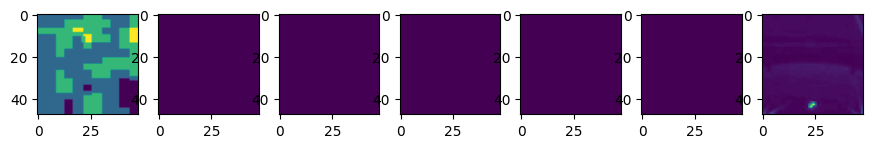

In [17]:
plt.figure(figsize=(20, 20))

j=1
for i in same_pixel_true_indices:
    img = np.squeeze(pixels[i].reshape(48, 48))
    plt.subplot(1, 13 ,j)
    plt.imshow(img)
    j += 1
plt.show()

In [18]:
# dropping images with only one color
df = df.drop(same_pixel_true_indices)

# displaying new train shape
print(f"New data Shape: {df.shape}")

New data Shape: (34087, 2)


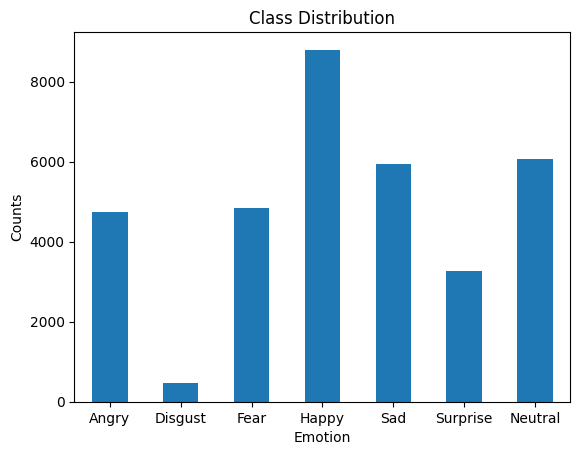

In [19]:
# storing emotion labels
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# calculating target distribution
cd = df["emotion"].value_counts().sort_index()

# plotting
cd.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(label_names)), labels=label_names, rotation=0)
plt.show()

In [20]:
## parsing data here
images, labels = parse_data(df)


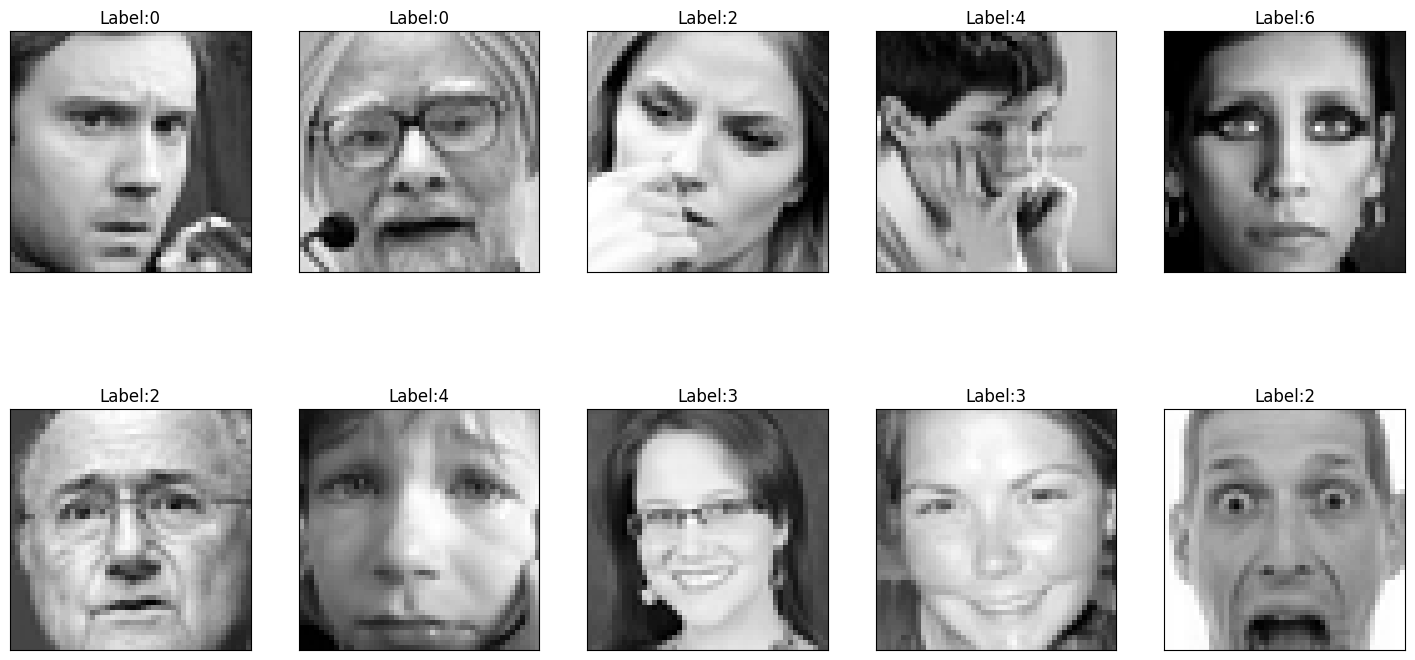

In [21]:
## showing images here
show_img(images, labels)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34087 entries, 0 to 35885
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  34087 non-null  int64 
 1   pixels   34087 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

Before PCA, shape is : 
(34087, 2304)


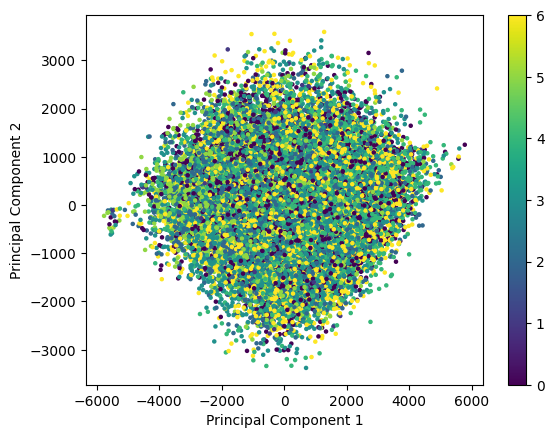

After PCA, shape is : 
(34087, 2)


In [23]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
images_reshaped = images.reshape((images.shape[0], -1)) # Chuyển đổi ảnh từ 48x48 sang dạng 1D
print("Before PCA, shape is : ")
print(images_reshaped.shape)
pca.fit(images_reshaped)
images_pca = pca.transform(images_reshaped)
# Hiển thị dữ liệu
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', s=5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()
print("After PCA, shape is : ")
print(images_pca.shape)


Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

Principal Component 1: 28.75%
Principal Component 2: 9.81%
Principal Component 3: 9.48%
Principal Component 4: 5.53%
Principal Component 5: 3.05%
Principal Component 6: 2.58%
Principal Component 7: 2.19%
Principal Component 8: 1.97%
Principal Component 9: 1.78%
Principal Component 10: 1.52%
Principal Component 11: 1.17%
Principal Component 12: 1.07%
Principal Component 13: 1.03%
Principal Component 14: 0.98%
Principal Component 15: 0.92%
Principal Component 16: 0.83%
Principal Component 17: 0.78%
Principal Component 18: 0.67%
Principal Component 19: 0.55%
Principal Component 20: 0.54%
Principal Component 21: 0.53%
Principal Component 22: 0.50%
Principal Component 23: 0.49%
Principal Component 24: 0.47%
Principal Component 25: 0.45%
Principal Component 26: 0.42%
Principal Component 27: 0.41%
Principal Component 28: 0.38%
Principal Component 29: 0.34%
Principal Component 30: 0.34%
Principal Component 31: 0.33%
Principal Component 32: 0.32%
Principal Component 33: 0.31%
Principal Componen

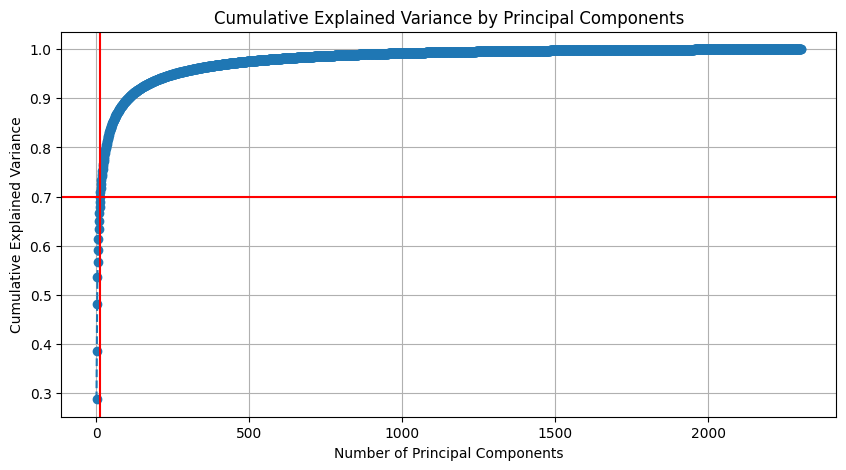

The optimal number of principal components to retain 70% of variance is: 14


In [24]:
# Áp dụng PCA
pca = PCA()
pca.fit(images_reshaped)

# Tính toán phương sai tích lũy
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# In ra % phương sai được giữ lại của từng thành phần chính
for i, variance in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {variance * 100:.2f}%")

# Vẽ biểu đồ phương sai tích lũy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.axhline(y=0.70, color='r', linestyle='-')
plt.axvline(x=np.argmax(cumulative_variance >= 0.70) + 1, color='r', linestyle='-')
plt.show()

# Số lượng thành phần chính tối ưu
optimal_components = np.argmax(cumulative_variance >= 0.7) + 1
print(f'The optimal number of principal components to retain 70% of variance is: {optimal_components}')

In [25]:
# Số lượng thành phần chính tối ưu
optimal_components = np.argmax(cumulative_variance >= 0.7) + 1
print(f'The optimal number of principal components to retain 70% of variance is: {optimal_components}')

The optimal number of principal components to retain 70% of variance is: 14


## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import cv2
import dlib
from skimage.feature import hog
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [ ]:
import numpy as np
import cv2
from skimage.feature import hog
import dlib
from sklearn.model_selection import train_test_split

# Load dlib's face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/ML/shape_predictor_68_face_landmarks.dat")

def extract_features(image):
    """
    Extracts facial landmarks and HOG features from a grayscale image.

    Parameters:
    - image: numpy array, input grayscale image (must be 8-bit grayscale)

    Returns:
    - combined_features: numpy array, concatenated array of facial landmarks and HOG features
    """
    # Ensure the image is 8-bit grayscale
    if len(image.shape) != 2 or image.dtype != np.uint8:
        raise ValueError("Image must be 8-bit grayscale")

    # Detect faces in the image
    rects = detector(image, 1)
    landmarks = np.zeros((68, 2))

    # For each detected face, extract facial landmarks
    for rect in rects:
        shape = predictor(image, rect)
        for i in range(68):
            landmarks[i] = (shape.part(i).x, shape.part(i).y)

    # Flatten landmarks into a 1D array
    landmarks = landmarks.flatten()

    # Extract HOG features from the image
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    # Combine facial landmarks and HOG features into a single feature vector
    combined_features = np.hstack([landmarks, hog_features])

    return combined_features

# Example usage:

# Assuming 'df' contains your data and you have already parsed it into images and labels
# For demonstration purposes, let's assume 'images' and 'labels' are defined

# Convert images to grayscale if they are in BGR format
images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image for image in images]
images = [image.astype(np.uint8) for image in images]

# Extract features for all images
features = [extract_features(image) for image in images]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets for verification
print(f"X_train shape: {np.array(X_train).shape}")
print(f"X_val shape: {np.array(X_val).shape}")
print(f"X_test shape: {np.array(X_test).shape}")
print(f"y_train shape: {np.array(y_train).shape}")
print(f"y_val shape: {np.array(y_val).shape}")
print(f"y_test shape: {np.array(y_test).shape}")


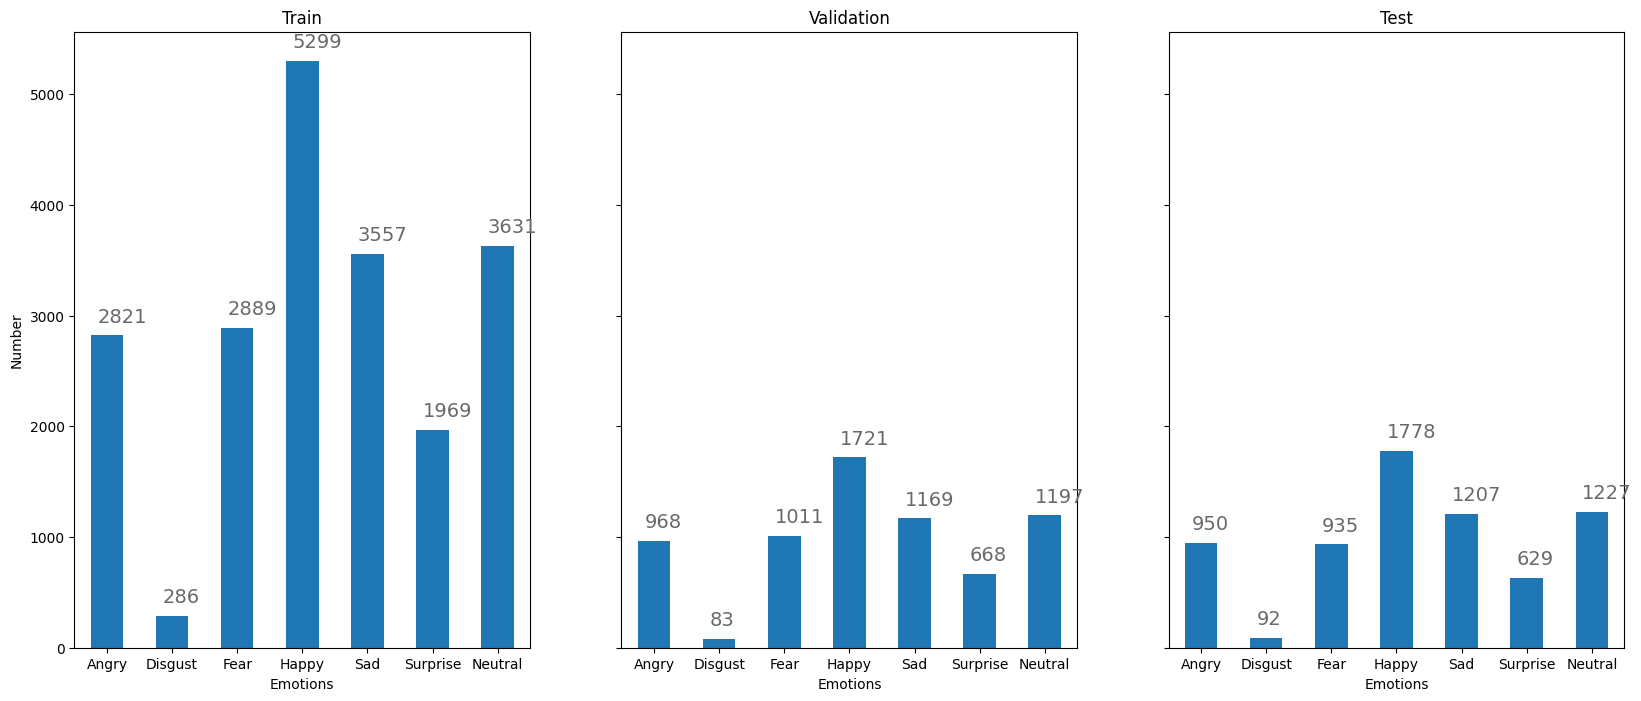

In [31]:
import matplotlib.pyplot as plt
import pandas as pd


emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe, labels, title):
    # Chuyển đổi danh sách thành Series để có thể sử dụng value_counts
    labels_series = pd.Series(labels)
    cd=labels_series.value_counts(sort=False).sort_index()
    cd.plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)

    # Đặt nhãn cho từng thanh
    for i in axe.patches:
        axe.text(i.get_x() + i.get_width() / 2. - 0.15, i.get_height() + 120, \
                str(int(i.get_height())), fontsize=14, color='dimgrey', rotation=0)

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
setup_axe(axes[0], y_train, 'Train')
setup_axe(axes[1], y_val, 'Validation')
setup_axe(axes[2], y_test, 'Test')
plt.show()


In [32]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define an improved DNN model
dnn_model = Sequential([
    Dense(512, activation='relu', input_shape=(1036,), kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(7, activation='softmax')
])

# Compile the model with a lower initial learning rate
optimizer = Adam(learning_rate=0.0005)
dnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with more epochs and the learning rate scheduler
history = dnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on test set
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy of DNN model: {test_acc:.4f}")


Epoch 1/50
640/640 [==============================] - 19s 21ms/step - loss: 2.8110 - accuracy: 0.2666 - val_loss: 2.2318 - val_accuracy: 0.3915 - lr: 5.0000e-04
Epoch 2/50
640/640 [==============================] - 11s 18ms/step - loss: 2.3460 - accuracy: 0.3491 - val_loss: 2.1341 - val_accuracy: 0.4179 - lr: 5.0000e-04
Epoch 3/50
640/640 [==============================] - 9s 15ms/step - loss: 2.2002 - accuracy: 0.3899 - val_loss: 2.0711 - val_accuracy: 0.4297 - lr: 5.0000e-04
Epoch 4/50
640/640 [==============================] - 11s 17ms/step - loss: 2.0945 - accuracy: 0.4162 - val_loss: 2.0013 - val_accuracy: 0.4379 - lr: 5.0000e-04
Epoch 5/50
640/640 [==============================] - 11s 18ms/step - loss: 2.0116 - accuracy: 0.4331 - val_loss: 1.9373 - val_accuracy: 0.4490 - lr: 5.0000e-04
Epoch 6/50
640/640 [==============================] - 10s 16ms/step - loss: 1.9500 - accuracy: 0.4435 - val_loss: 1.8863 - val_accuracy: 0.4580 - lr: 5.0000e-04
Epoch 7/50
640/640 [===============

In [33]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming X_train is a numpy array with class labels
unique_classes = np.unique(y_train)
class_labels = y_train.flatten()  # Flatten to get a flat list of class labels
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=class_labels)
class_weights_dict = dict(zip(unique_classes, class_weights))

# Print class weights for augmented data
print("Class Weights Dictionary for Augmented Data:")
for key, value in class_weights_dict.items():
    print(f"Class {key}: {value}")


Class Weights Dictionary for Augmented Data:
Class 0: 1.0357016255633766
Class 1: 10.215784215784216
Class 2: 1.011323740295703
Class 3: 0.5513708786024317
Class 4: 0.8213984497369372
Class 5: 1.4838569251977074
Class 6: 0.8046582995632844


In [34]:
# Extract features using CNN model's Flatten layer
train_features_dnn = dnn_model.predict(X_train)
test_features_dnn = dnn_model.predict(X_test)


214/214 [==============================] - 1s 4ms/step


In [52]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

# Mapping from labels (0-6) to emotion names
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Function to evaluate and print metrics
def evaluate_model(clf, X_test, y_test, y_pred_test, model_name):
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='weighted')

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=label_names))

    print(f"{model_name} Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_test)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{model_name} Confusion Matrix (Normalized)")
    plt.show()

# Define models for classification with class weights
models = {
    'Decision Tree': (DecisionTreeClassifier(class_weight=class_weights_dict), {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    }),
    'Logistic Regression': (LogisticRegression(max_iter=1000, class_weight=class_weights_dict), {'C': [0.1, 1, 10]}),
    'RandomForest': (RandomForestClassifier(class_weight=class_weights_dict), {
        'n_estimators': [50, 100, 200],
    }),
    'MLP': (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(20,), (50,), (20, 20), (100, 100)],
        'alpha': [0.001, 0.01]
    })
}


In [43]:
# Apply data with PCA
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)


Performance on Original Features (DNN Features):
Evaluating Decision Tree...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Decision Tree: Test Accuracy = 0.4834
Best Params for Decision Tree: {'criterion': 'gini', 'max_depth': 10}

Decision Tree Evaluation Metrics:
Precision: 0.4868
Recall: 0.4834
Accuracy: 0.4834
F1 Score: 0.4835

Decision Tree Classification Report:
              precision    recall  f1-score   support

       Angry       0.41      0.35      0.37       950
     Disgust       0.17      0.34      0.23        92
        Fear       0.33      0.27      0.30       935
       Happy       0.71      0.70      0.70      1778
         Sad       0.36      0.43      0.39      1207
    Surprise       0.57      0.57      0.57       629
     Neutral       0.46      0.46      0.46      1227

    accuracy                           0.48      6818
   macro avg       0.43      0.44      0.43      6818
weighted avg       0.49      0.48      0.48      6818

Decision Tree Con

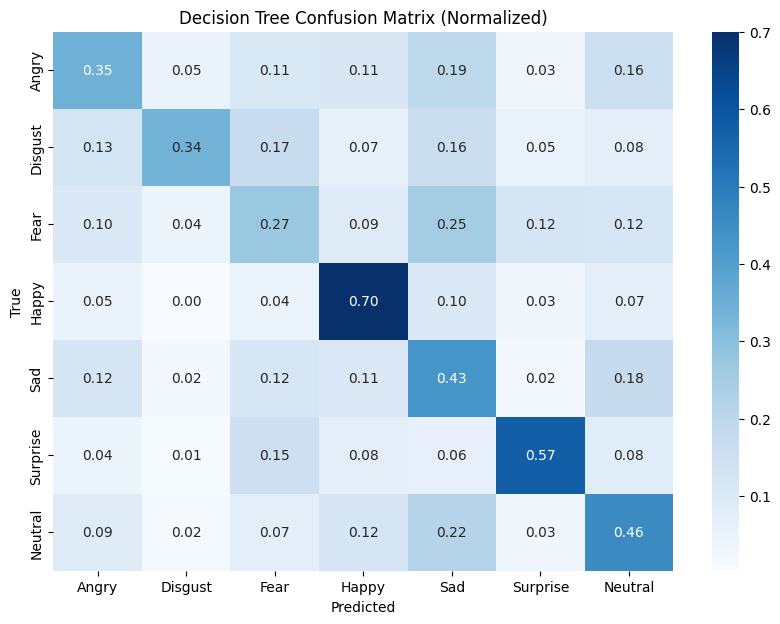

Evaluating Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression: Test Accuracy = 0.4950
Best Params for Logistic Regression: {'C': 0.1}

Logistic Regression Evaluation Metrics:
Precision: 0.4966
Recall: 0.4950
Accuracy: 0.4950
F1 Score: 0.4949

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       Angry       0.40      0.37      0.38       950
     Disgust       0.21      0.30      0.25        92
        Fear       0.34      0.28      0.31       935
       Happy       0.73      0.71      0.72      1778
         Sad       0.37      0.42      0.40      1207
    Surprise       0.57      0.59      0.58       629
     Neutral       0.46      0.48      0.47      1227

    accuracy                           0.50      6818
   macro avg       0.44      0.45      0.44      6818
weighted avg       0.50      0.50      0.49      6818

Logistic Regression Confusion Matrix:


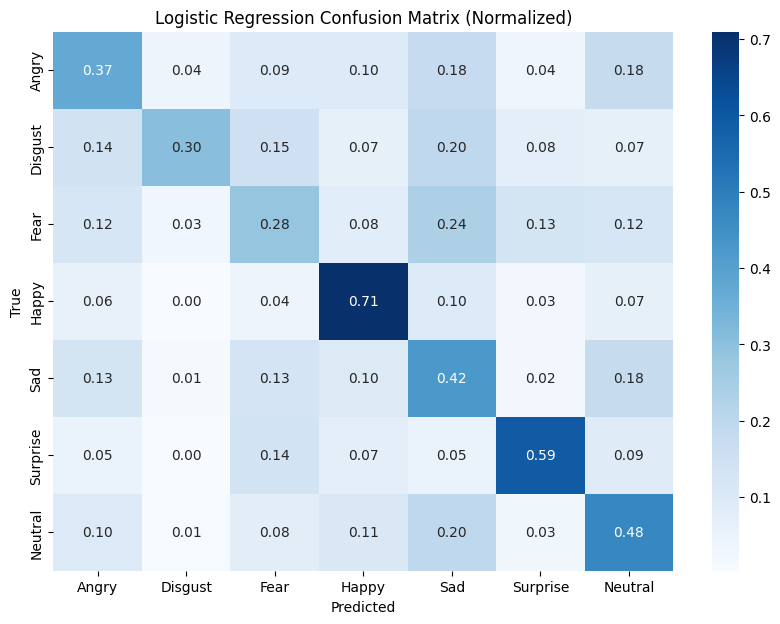

Evaluating RandomForest...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
RandomForest: Test Accuracy = 0.4965
Best Params for RandomForest: {'n_estimators': 200}

RandomForest Evaluation Metrics:
Precision: 0.4932
Recall: 0.4965
Accuracy: 0.4965
F1 Score: 0.4937

RandomForest Classification Report:
              precision    recall  f1-score   support

       Angry       0.40      0.38      0.39       950
     Disgust       0.40      0.18      0.25        92
        Fear       0.33      0.29      0.31       935
       Happy       0.71      0.73      0.72      1778
         Sad       0.37      0.42      0.40      1207
    Surprise       0.57      0.59      0.58       629
     Neutral       0.46      0.46      0.46      1227

    accuracy                           0.50      6818
   macro avg       0.46      0.44      0.44      6818
weighted avg       0.49      0.50      0.49      6818

RandomForest Confusion Matrix:


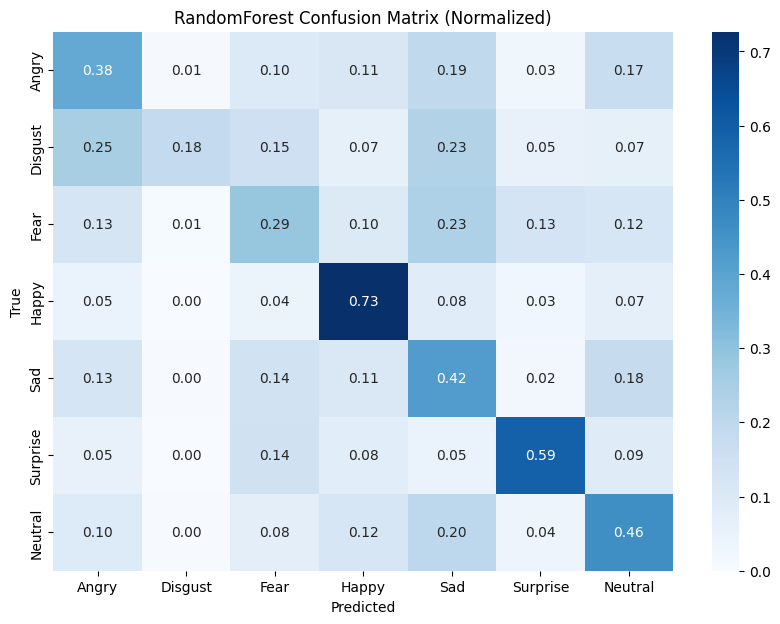

Evaluating MLP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
MLP: Test Accuracy = 0.5004
Best Params for MLP: {'alpha': 0.001, 'hidden_layer_sizes': (100, 100)}

MLP Evaluation Metrics:
Precision: 0.4988
Recall: 0.5004
Accuracy: 0.5004
F1 Score: 0.4982

MLP Classification Report:
              precision    recall  f1-score   support

       Angry       0.41      0.37      0.39       950
     Disgust       0.37      0.22      0.27        92
        Fear       0.34      0.28      0.31       935
       Happy       0.72      0.72      0.72      1778
         Sad       0.38      0.45      0.41      1207
    Surprise       0.56      0.59      0.57       629
     Neutral       0.46      0.48      0.47      1227

    accuracy                           0.50      6818
   macro avg       0.46      0.44      0.45      6818
weighted avg       0.50      0.50      0.50      6818

MLP Confusion Matrix:


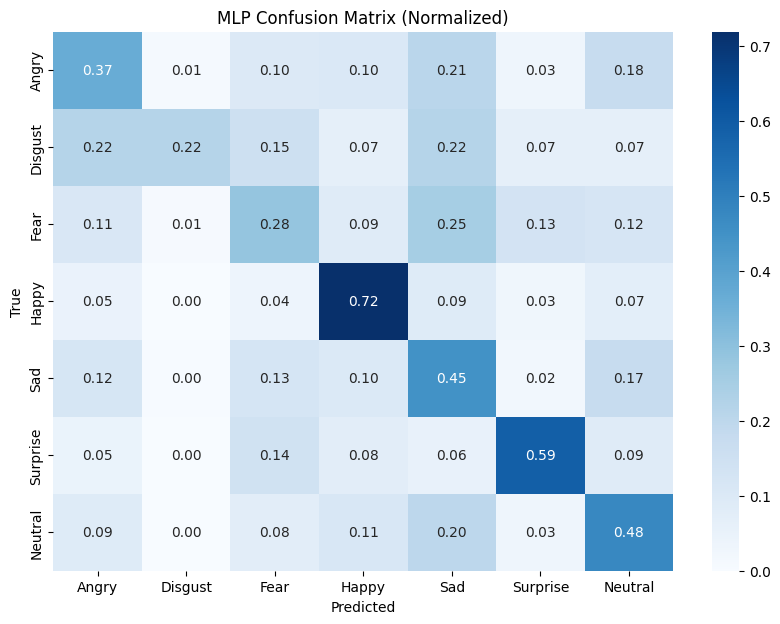

In [51]:
# Evaluate models on original features (DNN features)
print("\nPerformance on Original Features (DNN Features):")
for name, (model, param_grid) in models.items():
    print(f"Evaluating {name}...")
    clf = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
    clf.fit(train_features_dnn, y_train)
    y_pred_test = clf.predict(test_features_dnn)
    print(f"{name}: Test Accuracy = {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Best Params for {name}: {clf.best_params_}")
    evaluate_model(clf, test_features_dnn, y_test, y_pred_test, name)


Performance on PCA Data:
Evaluating Decision Tree...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Decision Tree: Test Accuracy = 0.2809
Best Params for Decision Tree: {'criterion': 'gini', 'max_depth': 10}

Decision Tree Evaluation Metrics:
Precision: 0.3093
Recall: 0.2809
Accuracy: 0.2809
F1 Score: 0.2903

Decision Tree Classification Report:
              precision    recall  f1-score   support

       Angry       0.20      0.19      0.19       950
     Disgust       0.05      0.25      0.08        92
        Fear       0.23      0.24      0.24       935
       Happy       0.51      0.41      0.46      1778
         Sad       0.28      0.21      0.24      1207
    Surprise       0.21      0.34      0.26       629
     Neutral       0.26      0.24      0.25      1227

    accuracy                           0.28      6818
   macro avg       0.25      0.27      0.24      6818
weighted avg       0.31      0.28      0.29      6818

Decision Tree Confusion Matrix:


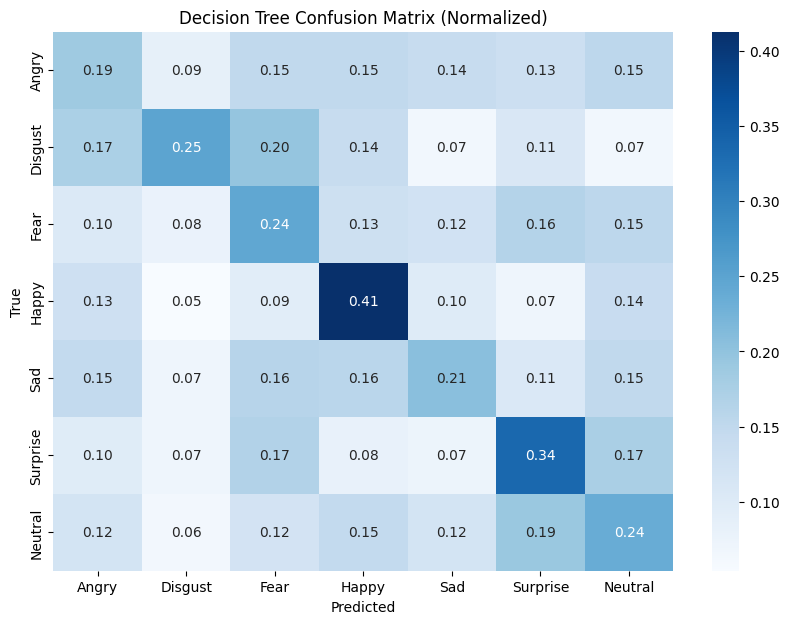

Evaluating Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression: Test Accuracy = 0.3206
Best Params for Logistic Regression: {'C': 1}

Logistic Regression Evaluation Metrics:
Precision: 0.3481
Recall: 0.3206
Accuracy: 0.3206
F1 Score: 0.3228

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       Angry       0.26      0.19      0.22       950
     Disgust       0.05      0.51      0.08        92
        Fear       0.20      0.08      0.12       935
       Happy       0.57      0.57      0.57      1778
         Sad       0.30      0.22      0.25      1207
    Surprise       0.27      0.49      0.35       629
     Neutral       0.32      0.24      0.27      1227

    accuracy                           0.32      6818
   macro avg       0.28      0.33      0.27      6818
weighted avg       0.35      0.32      0.32      6818

Logistic Regression Confusion Matrix:


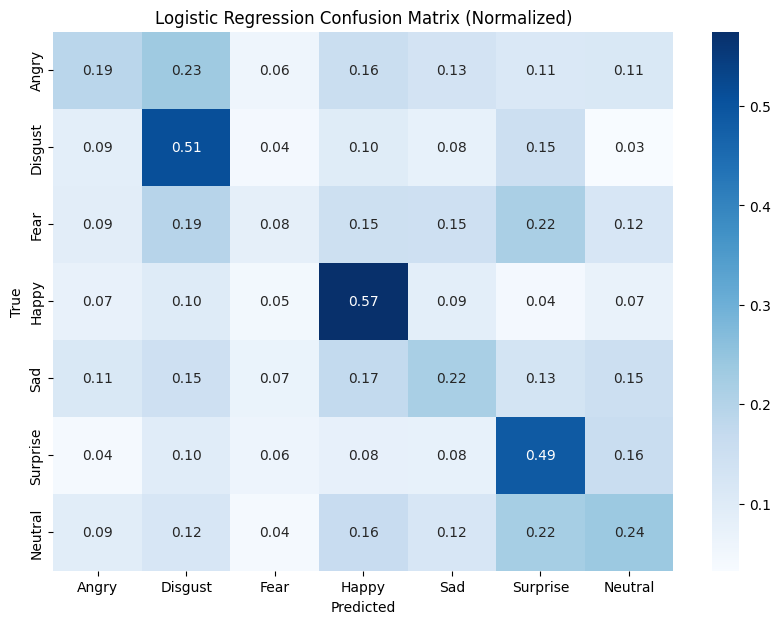

Evaluating RandomForest...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
RandomForest: Test Accuracy = 0.4204
Best Params for RandomForest: {'n_estimators': 200}

RandomForest Evaluation Metrics:
Precision: 0.4089
Recall: 0.4204
Accuracy: 0.4204
F1 Score: 0.3958

RandomForest Classification Report:
              precision    recall  f1-score   support

       Angry       0.37      0.21      0.27       950
     Disgust       0.60      0.03      0.06        92
        Fear       0.35      0.22      0.27       935
       Happy       0.49      0.77      0.60      1778
         Sad       0.35      0.36      0.35      1207
    Surprise       0.50      0.31      0.39       629
     Neutral       0.37      0.38      0.37      1227

    accuracy                           0.42      6818
   macro avg       0.43      0.33      0.33      6818
weighted avg       0.41      0.42      0.40      6818

RandomForest Confusion Matrix:


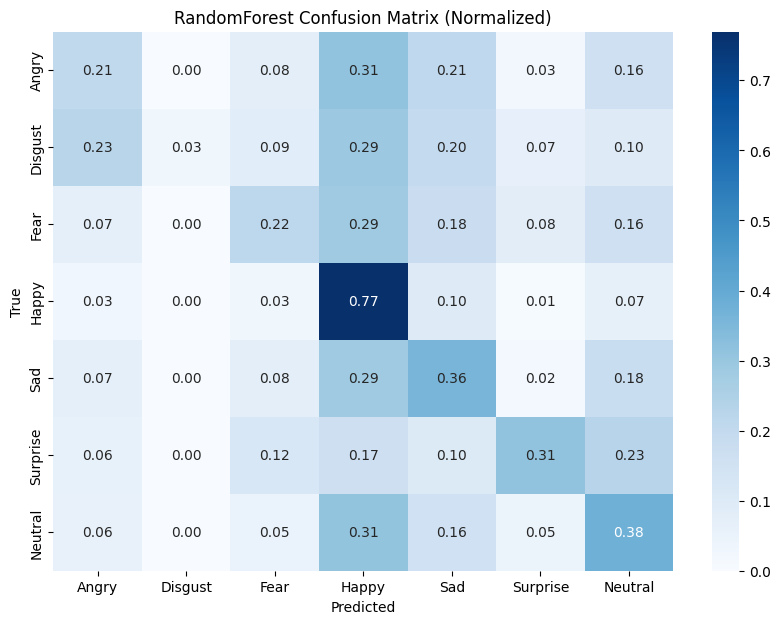

Evaluating MLP...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
MLP: Test Accuracy = 0.3921
Best Params for MLP: {'alpha': 0.001, 'hidden_layer_sizes': (20,)}

MLP Evaluation Metrics:
Precision: 0.3700
Recall: 0.3921
Accuracy: 0.3921
F1 Score: 0.3707

MLP Classification Report:
              precision    recall  f1-score   support

       Angry       0.31      0.18      0.23       950
     Disgust       0.33      0.01      0.02        92
        Fear       0.24      0.14      0.17       935
       Happy       0.53      0.70      0.60      1778
         Sad       0.29      0.33      0.31      1207
    Surprise       0.39      0.34      0.36       629
     Neutral       0.35      0.41      0.38      1227

    accuracy                           0.39      6818
   macro avg       0.35      0.30      0.30      6818
weighted avg       0.37      0.39      0.37      6818

MLP Confusion Matrix:


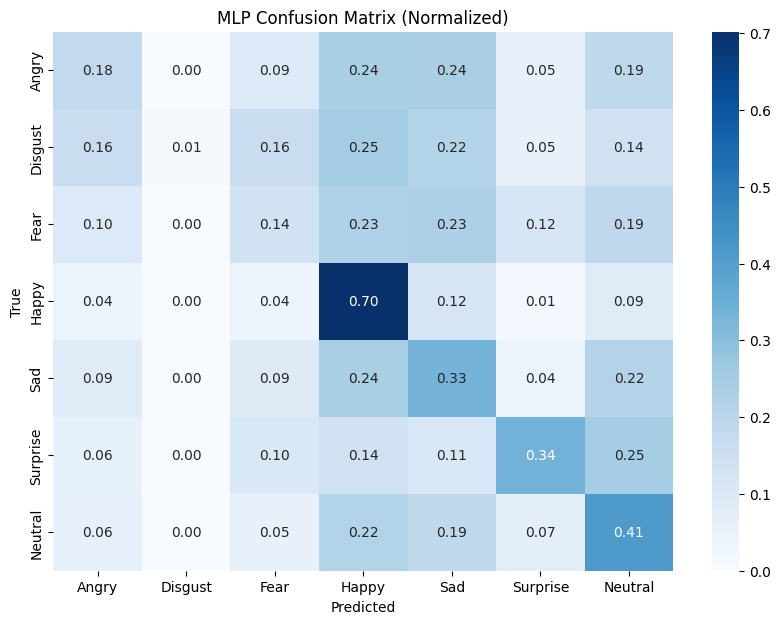

In [50]:
# Evaluate models on PCA Data
print("\nPerformance on PCA Data:")
for name, (model, param_grid) in models.items():
    print(f"Evaluating {name}...")
    clf = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
    clf.fit(X_train_pca, y_train)
    y_pred_test = clf.predict(X_test_pca)
    print(f"{name}: Test Accuracy = {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Best Params for {name}: {clf.best_params_}")
    evaluate_model(clf, X_test_pca, y_test, y_pred_test, name)


### Using CNN for emotions recognition

In [12]:
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.pixels, df.emotion, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [21]:
X_train.shape, X_val.shape, X_test.shape

((20456,), (6819,), (6819,))

In [22]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [23]:
def transform_data(features, label, dataName):
    # convert strings to lists of integers
    features = features.apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    # reshape and normalise grayscale image with 255.0
    data_X = np.array(features.tolist(), dtype='float32').reshape(-1,width, height,1)/255.0  
    # one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0] 
    data_Y = to_categorical(label, num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

In [24]:
X_train, y_train = transform_data(X_train, y_train, "train") #training data
X_val, y_val     = transform_data(X_val, y_val, "val") #validation data
X_test, y_test   = transform_data(X_test, y_test, "test") #test data

train _X shape: {},  train _Y shape: (20456, 48, 48, 1)
val _X shape: {},  val _Y shape: (6819, 48, 48, 1)
test _X shape: {},  test _Y shape: (6819, 48, 48, 1)


In [25]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 256)       0

d:\envs\ds-venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

##### Check GPU

In [27]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
with tf.device('/GPU:0'):
    history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size),
                                steps_per_epoch=len(X_train) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(X_val, y_val))

C:\Users\gohuy\AppData\Local\Temp\ipykernel_1124\3018906315.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size),


Epoch 1/50
319/319 - 92s - loss: 1.7608 - accuracy: 0.2832 - val_loss: 1.8036 - val_accuracy: 0.2958 - 92s/epoch - 288ms/step
Epoch 2/50
319/319 - 63s - loss: 1.5502 - accuracy: 0.3861 - val_loss: 1.8083 - val_accuracy: 0.3502 - 63s/epoch - 198ms/step
Epoch 3/50
319/319 - 63s - loss: 1.3794 - accuracy: 0.4635 - val_loss: 1.5305 - val_accuracy: 0.4348 - 63s/epoch - 198ms/step
Epoch 4/50
319/319 - 63s - loss: 1.2735 - accuracy: 0.5109 - val_loss: 1.2498 - val_accuracy: 0.5265 - 63s/epoch - 196ms/step
Epoch 5/50
319/319 - 63s - loss: 1.2130 - accuracy: 0.5362 - val_loss: 1.4615 - val_accuracy: 0.4530 - 63s/epoch - 197ms/step
Epoch 6/50
319/319 - 65s - loss: 1.1634 - accuracy: 0.5613 - val_loss: 1.4715 - val_accuracy: 0.4917 - 65s/epoch - 204ms/step
Epoch 7/50
319/319 - 68s - loss: 1.1303 - accuracy: 0.5709 - val_loss: 1.3663 - val_accuracy: 0.4636 - 68s/epoch - 214ms/step
Epoch 8/50
319/319 - 66s - loss: 1.1004 - accuracy: 0.5826 - val_loss: 1.1315 - val_accuracy: 0.5749 - 66s/epoch - 206

In [40]:
y_pred_test = model.predict(X_test)

214/214 [==============================] - 7s 32ms/step


In [58]:
y_pred_test = model.predict(X_test)
y_pred = np.argmax(y_pred_test , axis = 1 )

214/214 [==============================] - 7s 32ms/step


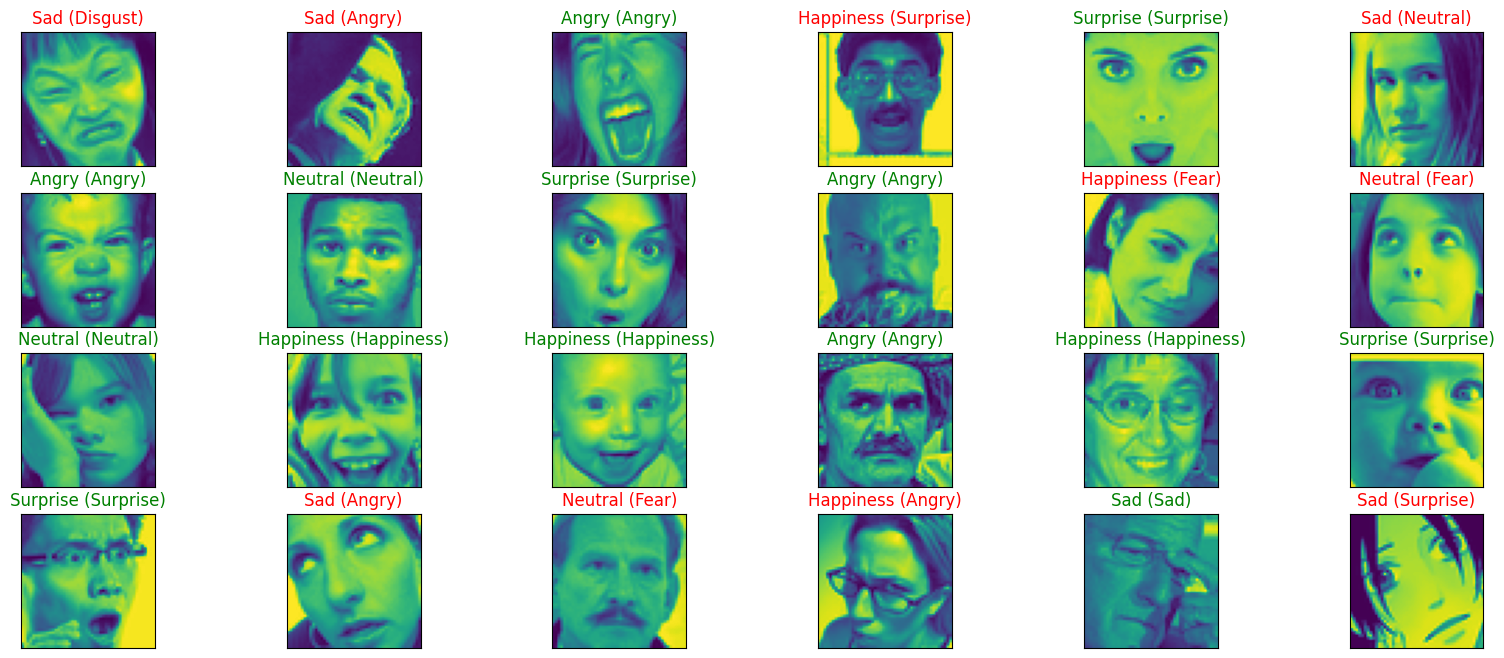

In [34]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [87]:
def evaluate_model(clf, X_test, y_test, y_pred_test, model_name):
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='weighted')

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=label_names))


In [71]:
y_pred_one_hot = np.zeros_like(y_pred_test)
y_pred_one_hot[np.arange(len(y_pred_test)), y_pred_test.argmax(axis=1)] = 1

In [88]:
evaluate_model(model, X_test, y_test, y_pred_one_hot, model_name="CNN")


CNN Evaluation Metrics:
Precision: 0.6191
Recall: 0.6087
Accuracy: 0.6087
F1 Score: 0.6051

CNN Classification Report:
              precision    recall  f1-score   support

       Angry       0.51      0.52      0.52       964
     Disgust       0.52      0.15      0.24        84
        Fear       0.51      0.32      0.39       944
       Happy       0.84      0.86      0.85      1766
         Sad       0.44      0.64      0.52      1180
    Surprise       0.79      0.63      0.70       661
     Neutral       0.56      0.53      0.54      1220

   micro avg       0.61      0.61      0.61      6819
   macro avg       0.60      0.52      0.54      6819
weighted avg       0.62      0.61      0.61      6819
 samples avg       0.61      0.61      0.61      6819



## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



`Accuracy:`
* On Original Features:
    - Decision Tree: 0.4834
    - Logistic Regression: 0.4950
    - RandomForest: 0.4965
    - MLP: 0.5004

* On PCA Data:
    - Decision Tree: 0.2809
    - Logistic Regression: 0.3206
    - RandomForest: 0.4204
    - MLP: 0.3921


`Precision:`
* On Original Features:
    - Decision Tree: 0.4868
    - Logistic Regression: 0.4966
    - RandomForest: 0.4932
    - MLP: 0.4988

* On PCA Data:
    - Decision Tree: 0.3093
    - Logistic Regression: 0.3481
    - RandomForest: 0.4089
    - MLP: 0.3700

`Recall:`
* On Original Features:
    - Decision Tree: 0.4834
    - Logistic Regression: 0.4950
    - RandomForest: 0.4965
    - MLP: 0.5004

* On PCA Data:
    - Decision Tree: 0.2809
    - Logistic Regression: 0.3206
    - RandomForest: 0.4204
    - MLP: 0.3921

`F1-score:`
* On Original Features:
    - Decision Tree: 0.4835
    - Logistic Regression: 0.4949
    - RandomForest: 0.4937
    - MLP: 0.4982 

* On PCA Data:
    - Decision Tree: 0.2903
    - Logistic Regression: 0.3228
    - RandomForest: 0.3958
    - MLP: 0.3707

`CNN Model on Original Data:`
- Accuracy: 0.6087
- Precision: 0.6191
- Recall: 0.6087
- F1-score: 0.6051

`Models on Original Data:`
- MLP has the highest accuracy, recall, and F1-score among traditional models (0.5004), yet it is still lower than CNN.
- CNN clearly outperforms the traditional models with an accuracy of 0.6087, precision of 0.6191, recall of 0.6087, and F1-score of 0.6051. This can be attributed to CNN's ability to effectively capture spatial features from images.

`Models on PCA Data:`
- RandomForest achieves the best performance among traditional models with an accuracy of 0.4204, precision of 0.4089, recall of 0.4204, and F1-score of 0.3958.
- The performance of other models significantly decreases when using PCA data. This could be due to PCA removing some crucial information necessary for accurate classification.

`Comparison between Original Data and PCA Data`: All models perform better on the original data compared to the PCA data. This indicates that dimensionality reduction using PCA might have led to the loss of important information required for accurate classification.

`Conclusion:`
- CNN is the best model for facial expression data on the original data, with performance superior to all traditional models (Decision Tree, Logistic Regression, RandomForest, and MLP). This is due to CNN's ability to learn complex features from images.
- RandomForest is the best traditional model on PCA data, though its performance is still lower than when using the original data.
- Using PCA data does not improve performance and instead reduces the effectiveness of most models. This suggests that PCA might not be suitable for this type of data or needs further tuning.

The `happy` expression outperforms the other expressions because: the data is unbalanced (the data labeled 'happy' is the most); naturally, the 'happy' expression is easier to recognize than the other expressions

`Reasons why the performance of the models is difficult to improve:`
- The data still contains irrelevant images (not facial expressions)
- There are images that do not clearly show expressions on the face (difficult to classify)
- There are initial data that are labeled with wrong expressions